In [1]:
from fastai import *
from fastai.vision.all import *
from models import SimpleAutoencoder

import sys
sys.path.append('..')
from src.band_plotters import *

from resnet_autoencoder import model

## Load

In [2]:
class Binarize(Transform):
    def __init__(self, threshold=0.8):self.threshold=threshold
    def encodes(self, o): 
        # print(o)
        mask = (o > (255 * self.threshold))
        return mask * 255

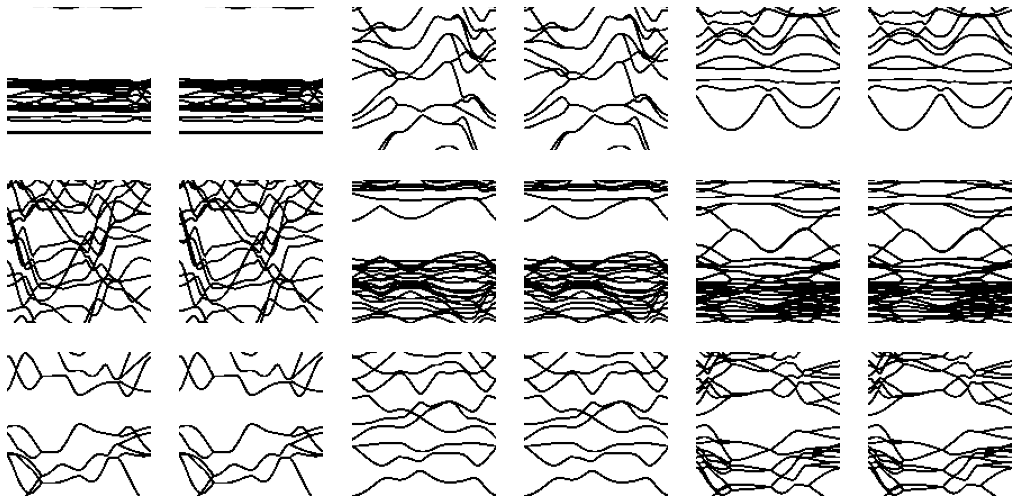

In [3]:
dls = DataBlock(
    blocks=(ImageBlock, ImageBlock), 
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.1, seed=42),
    item_tfms=[Resize((128))],
    batch_tfms=[Binarize()]
        ).dataloaders(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3", bs=32)

dls.show_batch()

In [4]:
xb, yb = dls.one_batch()
xb.shape

torch.Size([32, 3, 128, 128])

## Train

### Create Learner

In [5]:
def log_cosh_loss(pred, targ, a):
    loss = (1/a) * torch.log(torch.cosh(a*(pred-targ)))
    
    return loss.mean()

# loss = partial(log_cosh_loss, a=0.55)

epoch,train_loss,valid_loss,time
0,0.173940,0.150882,00:21
1,0.140655,0.135504,00:21
2,0.129726,0.126260,00:21
3,0.122039,0.120089,00:21
4,0.114268,0.114518,00:21
5,0.107322,0.104252,00:20
6,0.101672,0.101042,00:20
7,0.098835,0.100611,00:21
8,0.093947,0.096126,00:21
9,0.091756,0.093794,00:21


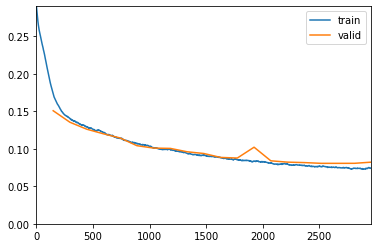

torch.Size([32, 16, 4, 4])


In [17]:
# for arch in ["resnet18"]:
loss = F.mse_loss
# loss = partial(log_cosh_loss, a=1)
# loss = nn.BCEWithLogitsLoss()
sigmoid = True
if isinstance(loss, nn.BCEWithLogitsLoss):
    sigmoid = False
ae = model.BuildAutoEncoder("resnet18", sigmoid=sigmoid, z_channels=16)
# ae = model.BigResNetAutoEncoder([2, 2, 2, 2], False, sigmoid)
learn = Learner(dls, ae, loss, cbs=[ShowGraphCallback()])
learn.fit_one_cycle(20)


xb, yb = dls.valid.one_batch()
# print(arch)
print(learn.model.encoder(xb.cuda()).shape)

## Save and Load Learner

<AxesSubplot:>

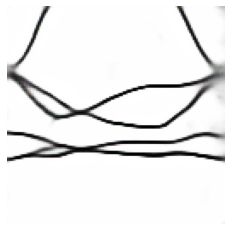

In [24]:
# learn.export("trained_models/resnet18_size128_lossMSE_channels16.pkl")
loaded = load_learner("trained_models/resnet18_size128_lossMSE_channels16.pkl")
out = loaded.predict(DATA_DIRECTORY/f"images/grayscale_4ev_linewidth3/2dm-1.png")
show_image(out[1])

## View Predictions

In [21]:
from ipywidgets import interact

def show(i):
    xb, yb = dls.valid.one_batch()
    preds = learn.model(xb)
    # if False:
    #     preds = F.sigmoid(preds)
    print(preds.shape)
    show_image(xb[i])
    show_image(preds[i])

    

interact(show, i=(0, len(xb)-1))

interactive(children=(IntSlider(value=15, description='i', max=31), Output()), _dom_classes=('widget-interact'…

<function __main__.show(i)>